Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [x]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>]],
      dtype=object)

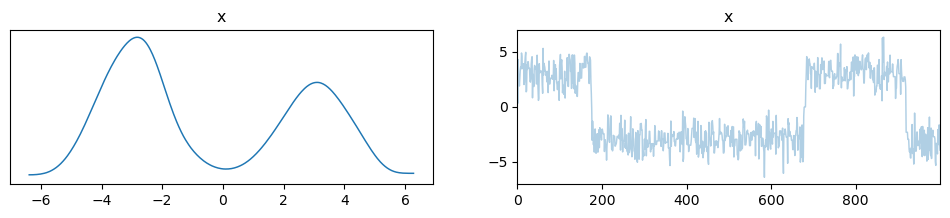

In [25]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import arviz as az

# Define a log probability function
def logp_bimodal(value):
    """
    Bimodal log probability: A mixture of two normal distributions.
    """
    logp1 = -0.5 * ((value - 3) / 1) ** 2  # Normal(3, 1)
    logp2 = -0.5 * ((value + 3) / 1) ** 2  # Normal(-3, 1)
    return pt.log(0.5 * pt.exp(logp1) + 0.5 * pt.exp(logp2))


# PyMC model
with pm.Model() as model:

    x = pm.CustomDist("x", logp=logp_bimodal)

    trace = pm.sample(1000, chains =1, return_inferencedata=True)

# Plot results
az.plot_trace(trace)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [x]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>]],
      dtype=object)

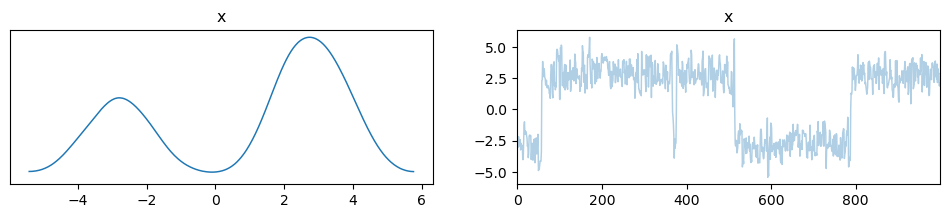

In [17]:

# PyMC Model
with pm.Model() as model:
    # Define an unconstrained variable (continuous support)
    x = pm.Normal("x", mu=0, sigma=5)  # Broad prior

    # Assign custom log probability using Potential
    pm.Potential("bimodal_logp", logp_bimodal(x))

    # Sample from the posterior
    trace = pm.sample(1000, chains=1, return_inferencedata=True)

# Plot results
az.plot_trace(trace)


In [29]:
import pymc as pm
import pytensor.tensor as pt
import numpy as np

def neals_funnel_logp(v, x):
    n = x.shape[0]
    
    # Log-Dichte für v ~ N(0, 3^2)
    logp_v = -0.5 * (v**2 / 9) - 0.5 * np.log(18 * np.pi)

    # Log-Dichte für x | v ~ N(0, exp(v))
    logp_x = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * v - 0.5 * pt.sum(x**2 / pt.exp(v))
    
    return logp_v + logp_x

# PyMC-Modell definieren
with pm.Model() as model:
    v = pm.Normal("v", mu=0, sigma=3)
    x = pm.CustomDist("x", v, logp=neals_funnel_logp, shape=(10,))
    
    trace = pm.sample(1000, cores=2, chains=2, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v, x]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>],
       [<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>]],
      dtype=object)

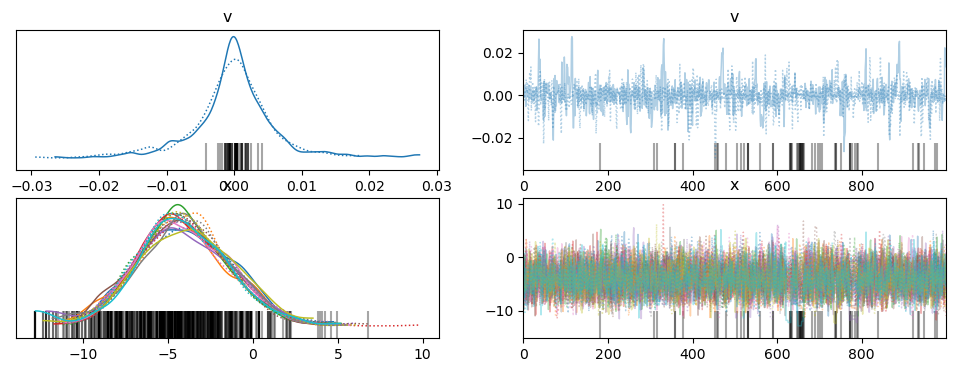

In [30]:
# Visualize the results
az.plot_trace(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rosenbrock]


Output()

Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


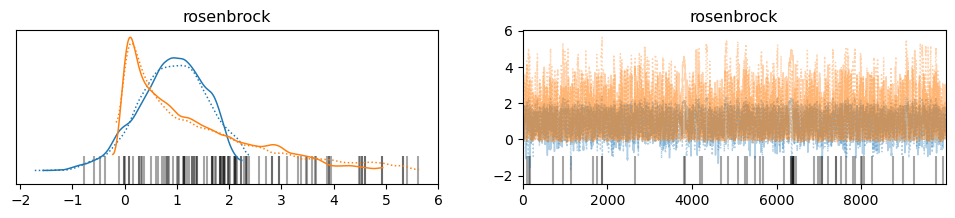

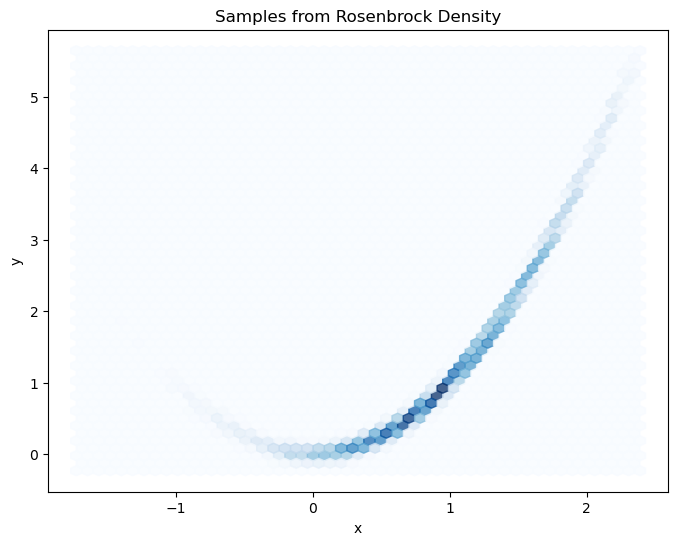

In [33]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Define the Rosenbrock log-probability function
def rosenbrock_logp(value, a=1, b=100, T=1):
    """Log-probability function for the Rosenbrock 'banana' density."""
    x, y = value  # Unpack the variables
    return -((a - x) ** 2 + b * (y - x ** 2) ** 2) / T

# Implement PyMC Model
with pm.Model() as model:
    # Define the custom distribution
    rosenbrock = pm.CustomDist("rosenbrock", logp=rosenbrock_logp, shape=(2,))

    # Sampling using Metropolis-Hastings and NUTS
    trace = pm.sample(10000, tune=1000, chains=2, cores=2, target_accept=0.9)

# Visualizing the Results
az.plot_trace(trace)
plt.show()

# Joint plot of sampled points
x_samples = trace.posterior["rosenbrock"][:, :, 0].values.flatten()
y_samples = trace.posterior["rosenbrock"][:, :, 1].values.flatten()

plt.figure(figsize=(8,6))
plt.hexbin(x_samples, y_samples, gridsize=50, cmap="Blues", alpha=0.75)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Samples from Rosenbrock Density")
plt.show()


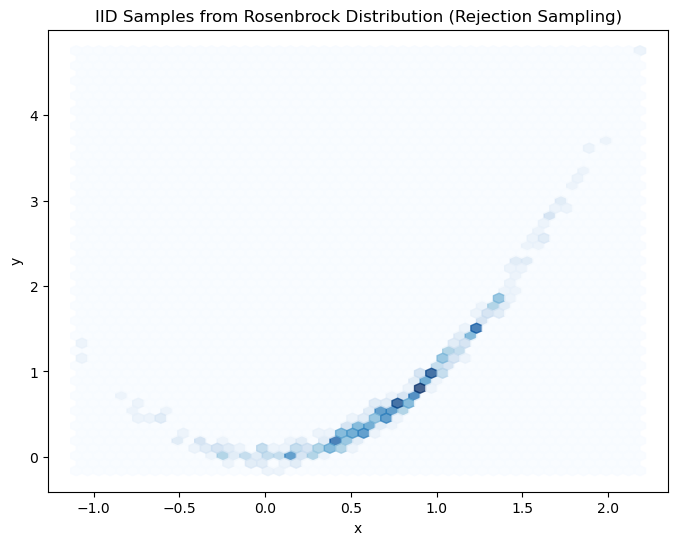

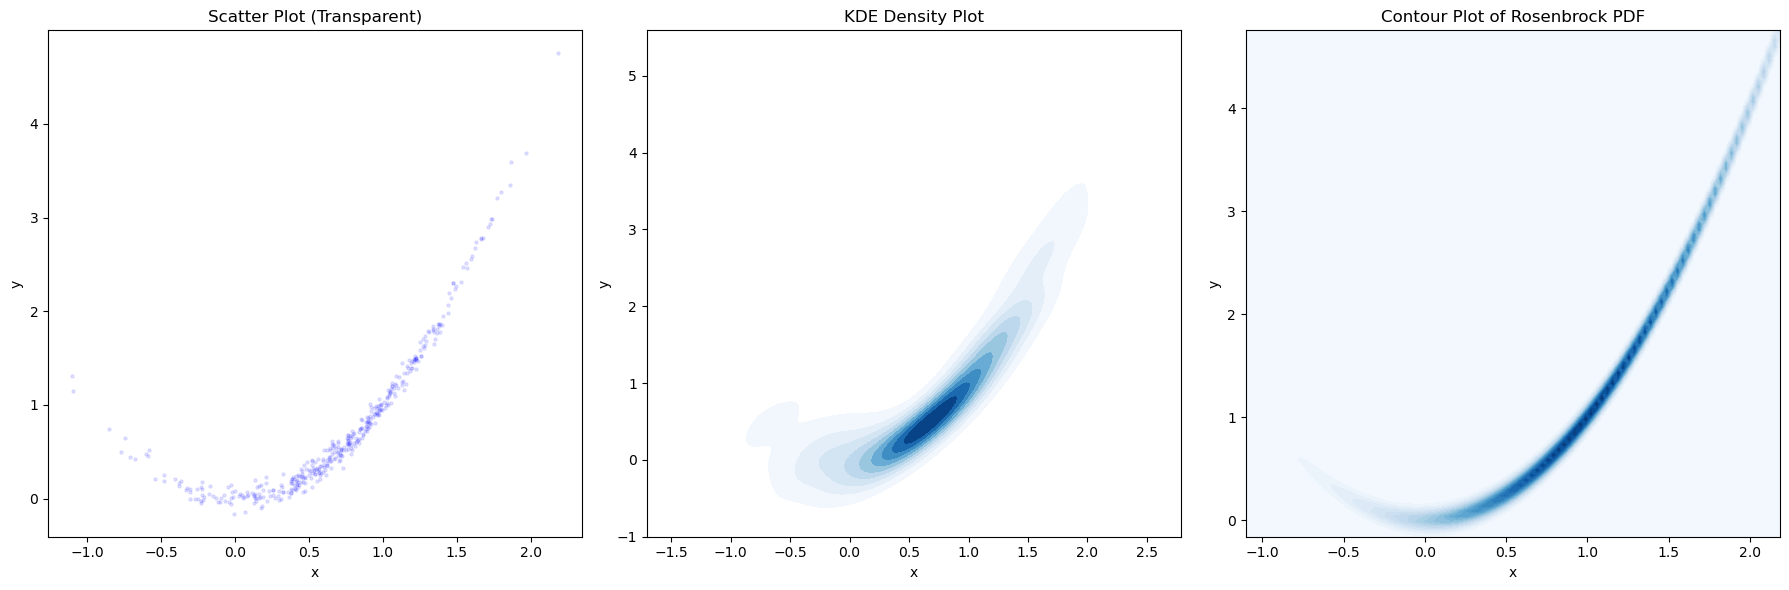

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Define the Rosenbrock PDF (up to a normalization constant)
def rosenbrock_pdf(x, y, a=1, b=100, T=1):
    return np.exp(-((a - x) ** 2 + b * (y - x ** 2) ** 2) / T)

# Proposal distribution: A broad Gaussian
def proposal_distribution(size):
    return np.random.normal(loc=0, scale=2, size=size)

# Rejection Sampling
def sample_rosenbrock(num_samples):
    samples = []
    num_accepted = 0
    max_attempts = 10 * num_samples  # To avoid infinite loops

    while num_accepted < num_samples and max_attempts > 0:
        max_attempts -= 1
        x_proposed = proposal_distribution(1)
        y_proposed = proposal_distribution(1)
        
        # Compute the acceptance probability
        p_accept = rosenbrock_pdf(x_proposed, y_proposed)
        
        # Accept/reject step
        if np.random.uniform(0, 1) < p_accept:
            samples.append([x_proposed[0], y_proposed[0]])
            num_accepted += 1
    
    return np.array(samples)

# Generate IID samples
iid_samples = sample_rosenbrock(5000)

# Plot the results
plt.figure(figsize=(8,6))
plt.hexbin(iid_samples[:,0], iid_samples[:,1], gridsize=50, cmap="Blues", alpha=0.75)
plt.xlabel("x")
plt.ylabel("y")
plt.title("IID Samples from Rosenbrock Distribution (Rejection Sampling)")
plt.show()


# Plot the Rosenbrock samples with different techniques
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot with transparency
axes[0].scatter(iid_samples[:, 0], iid_samples[:, 1], alpha=0.1, s=5, color="blue")
axes[0].set_title("Scatter Plot (Transparent)")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

# Kernel Density Estimate (KDE) plot
sns.kdeplot(x=iid_samples[:, 0], y=iid_samples[:, 1], fill=True, cmap="Blues", ax=axes[1])
axes[1].set_title("KDE Density Plot")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")

# Contour Plot
x = np.linspace(min(iid_samples[:, 0]), max(iid_samples[:, 0]), 100)
y = np.linspace(min(iid_samples[:, 1]), max(iid_samples[:, 1]), 100)
X, Y = np.meshgrid(x, y)

# Compute Rosenbrock PDF on a grid
Z = np.exp(-((1 - X)**2 + 100*(Y - X**2)**2))

# Contour levels
axes[2].contourf(X, Y, Z, levels=30, cmap="Blues")
axes[2].set_title("Contour Plot of Rosenbrock PDF")
axes[2].set_xlabel("x")
axes[2].set_ylabel("y")

plt.tight_layout()
plt.show()